<a href="https://colab.research.google.com/github/kushalbakshi/NeuroMatch_Project/blob/main/Feedback_related_spiking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt

In [2]:
#@title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)


In [3]:
#@title Data loading
import numpy as np
from math import nan

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

In [4]:
def get_responses_steinmetz(alldat, k):
    #alldat is all the steinmetz data
    #k is the session number that you wish to extract
    dat=alldat[k]
    brain_area = dat['brain_area']
    responses=dat['response']
    feedback_time = dat['feedback_time']
    feedback= dat['feedback_type']
    prev_reward = dat['prev_reward']
    contrast_diff = dat['contrast_right']-dat['contrast_left']
    reaction_time = dat['reaction_time']
    spks = dat['spks']
    keys_list = ['brain_area', 'response', 'feedback_time', 'feedback_type', 'prev_reward', 'contrast diff', 'reaction_time', 'spks']
    values_list = [brain_area, responses, feedback_time, feedback, prev_reward, contrast_diff, reaction_time, spks]
    zip_iterator = zip(keys_list, values_list)
    global session_responses_dict
    session_responses_dict = dict(zip_iterator)

In [5]:
get_responses_steinmetz(alldat, 17)
brain_area_idx = np.where(session_responses_dict['brain_area'] == 'SNr')
feedback_time = session_responses_dict['feedback_time']

In [7]:
del session_responses_dict
del alldat
del get_responses_steinmetz

In [8]:
#@title Data retrieval
import os, requests

fname = ['steinmetz_st.npz']
fname.append('steinmetz_wav.npz')
fname.append('steinmetz_lfp.npz')

url = ["https://osf.io/4bjns/download"]
url.append("https://osf.io/ugm9v/download")
url.append("https://osf.io/kx3v9/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)


In [9]:
#@title Data loading
import numpy as np

#dat_LFP = np.load('steinmetz_lfp.npz', allow_pickle=True)['dat']
#dat_WAV = np.load('steinmetz_wav.npz', allow_pickle=True)['dat']
dat_ST = np.load('steinmetz_st.npz', allow_pickle=True)['dat']


# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. 
#dat = dat_LFP[11]
#print(dat.keys())
#dat = dat_WAV[11]
#print(dat.keys())
#dat = dat_ST[11]
#print(dat.keys())

In [10]:
# Imports spike times from recording session 'k'
# ACB_spikes imports the spike times. Poor variable naming choice on my part. It will have spike times no matter what the brain region.

def get_spike_times(dat_ST, k):
  dat = dat_ST[k]
  global spike_times
  spike_times = dat['ss']
get_spike_times(dat_ST, 17)
ACB_spikes = spike_times[brain_area_idx]
neuron_n = len(ACB_spikes)
trial_n = len(ACB_spikes[0])

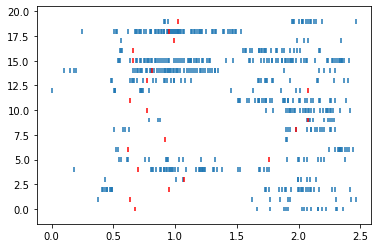

In [25]:
# Raster plot of 20 trials from ACB_spikes
# Structure is ACB_spikes[neuron number][trial number]
# Red is feedback presentation time
for n in range(0, 20):
  plt.eventplot(ACB_spikes[4][n], lineoffsets=0+n, linelengths=0.5)
  plt.eventplot(feedback_time[n], lineoffsets=0+n, linelengths=0.5, color='red')

In [18]:
# Main data cell to calculate post and pre feedback ISI and post feedback first spike latency
# Latencies are averaged across 316 trials in the cell below (median)
post_fb_spikes = []
pre_fb_spikes = []
post_fb_isi = []
post_fb_latency = []
for n in range(0, neuron_n):
  for m in range(0, trial_n):
    try:
      post_fb_spikes_mat = ACB_spikes[n][m][np.where(ACB_spikes[n][m] > feedback_time[m])]
      post_fb_isi_mat = np.diff(post_fb_spikes_mat)*1000
      post_fb_latency_mat = (post_fb_spikes_mat[0] - feedback_time[m])*1000
      pre_fb_spikes_mat = ACB_spikes[n][m][np.where(ACB_spikes[n][m] < feedback_time[m])]
    except ValueError:
      post_fb_spikes_mat = np.array(np.nan)
      post_fb_isi_mat = np.array(np.nan)
    except IndexError:
      post_fb_latency_mat = np.array(np.nan)
      pre_fb_spikes_mat = np.array(np.nan)
    post_fb_spikes.append(post_fb_spikes_mat)
    pre_fb_spikes.append(pre_fb_spikes_mat)
    post_fb_isi.append(post_fb_isi_mat)
    post_fb_latency.append(post_fb_latency_mat)
post_fb_latency = np.asarray(post_fb_latency, dtype='float64')

In [19]:
average_post_latency = np.zeros((neuron_n,1))
for n in range(1, neuron_n):
  average_post_latency[n-1] = np.nanmedian(post_fb_latency[trial_n*(n-1):trial_n*n])

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
